<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/eras/eras/tune/programs/analyzer_next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 前処理
# import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep
# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
# others
import json
from collections import OrderedDict
import pprint


# gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm to build gdrive")

# colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")


Mounted at /content/drive
Created at /content/desk


#データをインポート

In [29]:
pathHistories = "/content/drive/MyDrive/colab/histories"
os.chdir(pathHistories)

history_directories = os.listdir(pathHistories)
history_directories.remove('.ipynb_checkpoints')
history_directories.reverse()

for each in history_directories:
  print(each)

0114-2350
0114-2347
0114-2341
0114-2340
0114-2339
0114-2338
0114-2229
0114-2131
0114-1910
0114-1843
0114-1820
0114-1337
0114-1303
0114-1228
0114-1143
0114-1105
0113-2131
0113-1929
0113-1820
0113-1734
0113-1649
0113-1510
0113-1408
0112-1834
0112-1631
0112-1552


In [30]:
pickups = [0]

In [46]:
#@title 読み込み
import re

examines = []

csv_pattern = re.compile(".*\.csv")  

# cce_pattern = re.compile("CategoricalCrossentropy.*")
# mse_pattern = re.compile("MeanSquaredError.*")

# loss_patterns = [
#                  re.compile("CategoricalCrossentropy.*"),
#                  re.compile("MeanSquaredError.*"),
#                  re.compile("SquaredHinge.*"),
#                  re.compile("MeanAbsoluteError.*")            
# ]
losses = [
                 "CategoricalCrossentropy",
                 "MeanSquaredError",
                 "SquaredHinge",
                 "MeanAbsoluteError"]


json_pattern = re.compile(".*\.json")

for pick_one in pickups:
  print("the directory : ", history_directories[pick_one])
  inFiles = os.listdir(history_directories[pick_one])
  print("in:", inFiles)

  csvs = []
  for file in inFiles:
    file_path = os.path.join(pathHistories, history_directories[pick_one])
    file_path = os.path.join(file_path, file)
    # when csv files    
    if csv_pattern.match(file):
      # それを変数として取り込む
      for each_loss in losses:
        if re.compile(each_loss+".*").match(file):
          print("read : ", each_loss)
          page = {
              "loss" : each_loss,
              "data" : pd.read_csv(file_path, engine='python') 
          }
        else:
          pass
      csvs.append(page)
    elif json_pattern.match(file):
      with open(file_path) as f:
        json_load = json.load(f) 
      print("read :  json file")
  
  #/for file
  examines.append(csvs)
  print("-----------------------------------------------------------------------------------------------------")
#/for

the directory :  0114-2350
in: ['CategoricalCrossentropy_0114-2350.csv', 'situation.json', 'SquaredHinge_0114-2350.csv', 'MeanAbsoluteError_0114-2350.csv']
read :  CategoricalCrossentropy
read :  json file
read :  SquaredHinge
read :  MeanAbsoluteError
-----------------------------------------------------------------------------------------------------


In [9]:
#@title プロット機能
def plot_one_learning(one_learning, useLoss, end_point, experiment_name="No name"):
  HEIGHT = 1
  WIDTH = 4

  rate = 9.0
  fig = plt.figure(figsize=(WIDTH*rate*2, HEIGHT*rate))

  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1) # loss, val_loss
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2) # acc, val_acc
  LOSS_head = fig.add_subplot(HEIGHT, WIDTH, 3) # head of loss, val_loss
  MEMO =  fig.add_subplot(HEIGHT, WIDTH, 4) # memo
  # plt.subplots_adjust(left=None, bottom=None, right=2.0, top=1.5, wspace=0.5, hspace=0.5)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
  # 1,1 loss
  loss = one_learning["loss"]
  val_loss = one_learning["val_loss"]

  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = one_learning['acc']
  val_acc = one_learning['val_acc']
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  crisis_data = [
                 (one_learning["acc"][len(one_learning["acc"]) - 1], 'last acc'),
                 (format(one_learning["val_acc"][len(one_learning["val_acc"]) - 1], '.6f'), 'last val_acc')
  ]

  ACC.set(**acc_props)
  ACC.text(0.8, 0.17, crisis_data_write(crisis_data), ha='right', va='top', transform=ACC.transAxes, size=10)
   

  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

# 1,3 loss head
  end_point = end_point
  loss_head = one_learning["loss"][:end_point]
  val_loss_head = one_learning["val_loss"][:end_point]
  loss_head_props = {
        # 'title' : 'Loss values plot [0 - 100]',
        'title' : 'Loss values plot [0 - ' + str(end_point) + ']',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  LOSS_head.set(**loss_head_props)
  LOSS_head.plot(loss_head, label='loss_head', color='blue')
  LOSS_head.plot(val_loss_head, label='val_loss_head', color='orange')
  LOSS_head.legend(loc='best')
  
# 1,4 memo
  tmp = {
      'title' : 'memo',
      'xticks' : ([]),
      'yticks' : ([]),
  }

  MEMO.set(**tmp)
  MEMO.text(0.11, 0.24, memo_write(useLoss, experiment_name), size=24)

  #save
  save_dir = os.path.join(desk, experiment_name)
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)

  path_image = os.path.join(save_dir, useLoss+experiment_name)
  fig.savefig(path_image, bbox_inches='tight')


def memo_write(useLoss, experiment_name):
  sentence = ""
  sentence += useLoss + " is used as a loss function\n\n"
  sentence += pprint.pformat(json_load) + "\n\n"
  sentence += "The Directory name : " + experiment_name
  return sentence

def crisis_data_write(crisis_data):
  sentence = ""
  sentence += str(crisis_data[0][1]) + " = " + str(crisis_data[0][0]) + "\n"
  sentence += str(crisis_data[1][1]) + " = " + str(crisis_data[1][0]) + "\n"
  return sentence



display :  0114-2350
CategoricalCrossentropy
SquaredHinge
MeanAbsoluteError


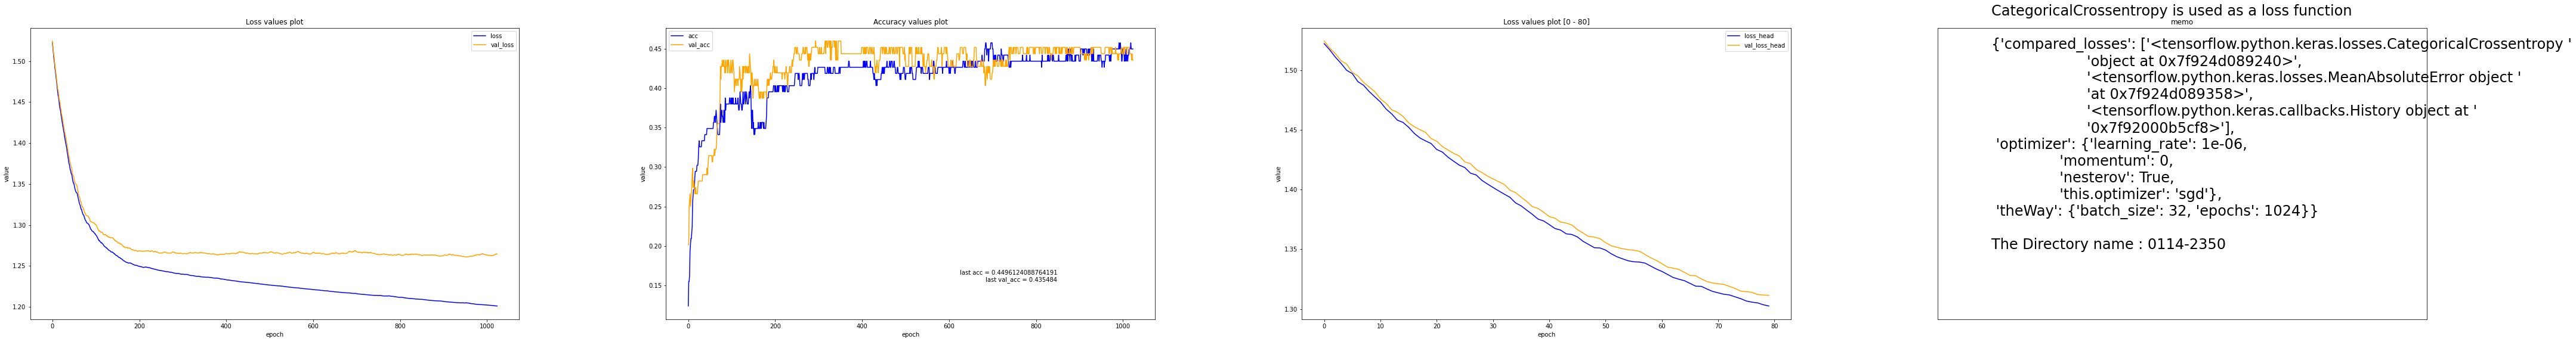

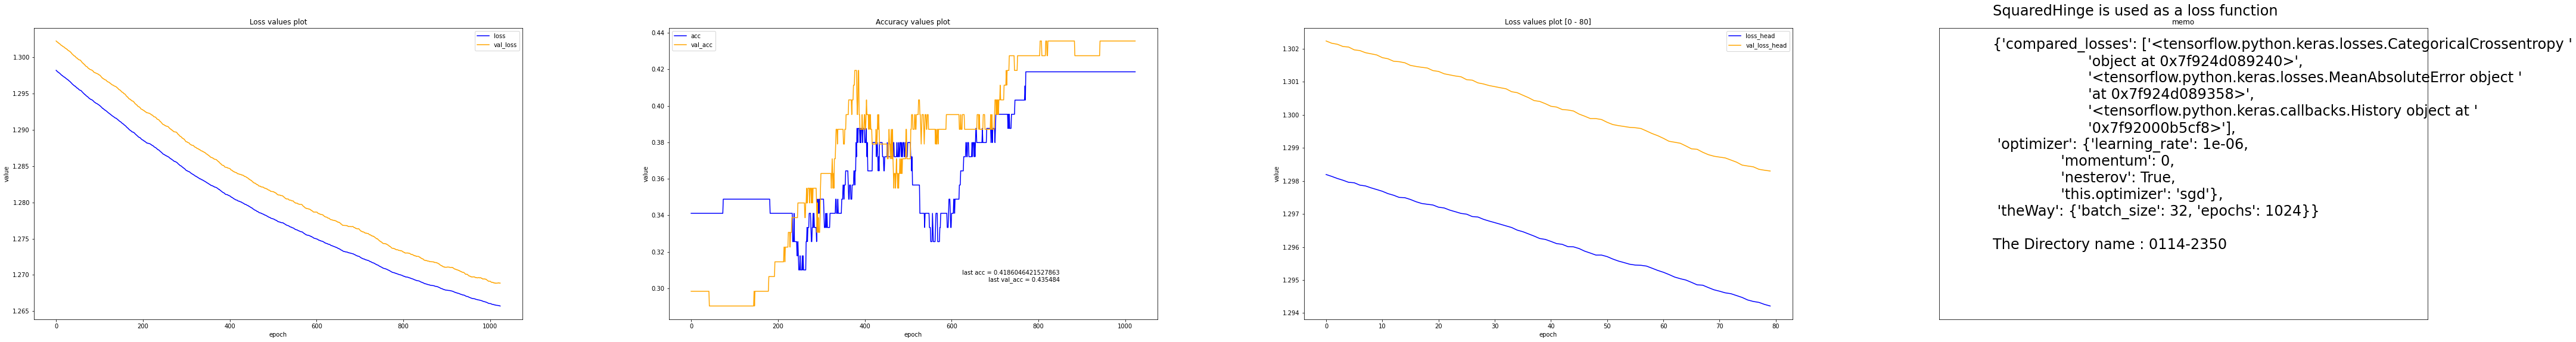

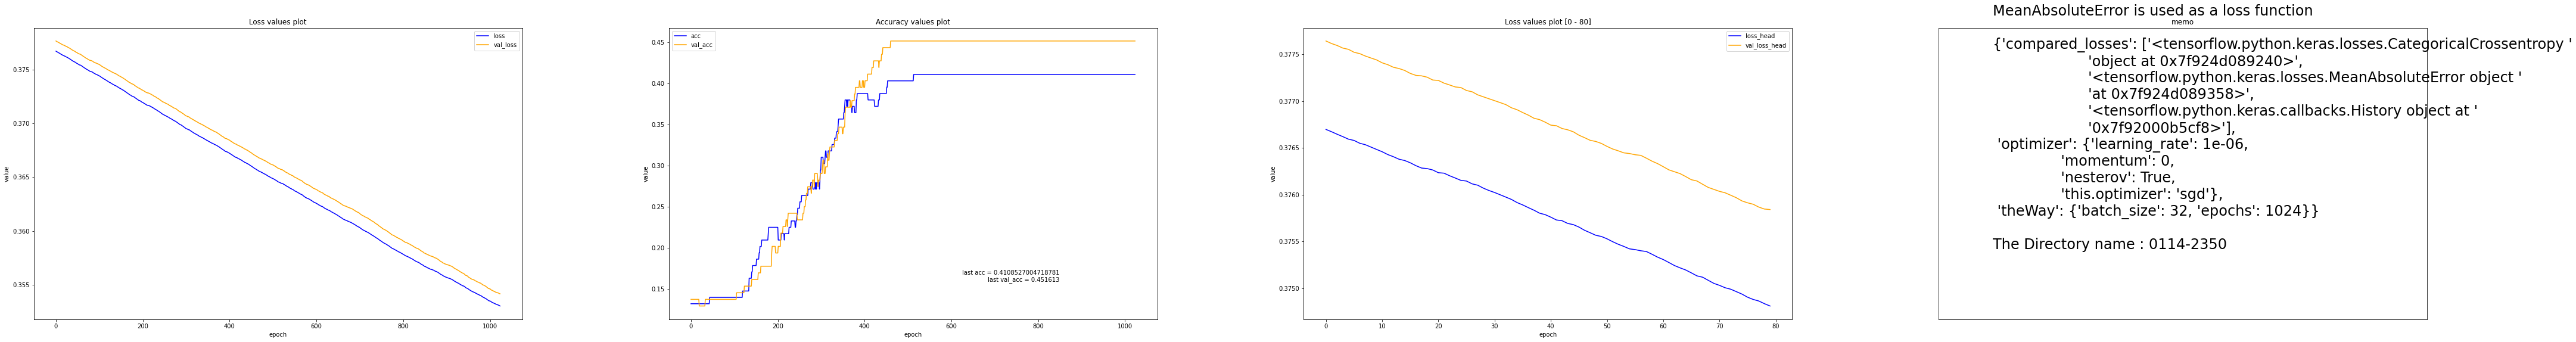

In [55]:
tmp = 0
print("display : ", history_directories[pickups[tmp]])
for each_loss_csv in examines[tmp]:
  print(each_loss_csv["loss"])
  plot_one_learning(each_loss_csv["data"], each_loss_csv["loss"], 80, history_directories[pickups[tmp]])
# print(examines[tmp][1]["loss"])
# plot_one_learning(examines[tmp][1]["data"], examines[tmp][1]["loss"], 80, history_directories[pickups[tmp]])

In [6]:
# len(examines[0])

# # for each in history_directories:

# for each in range(len(examines)):
#   print("display : ", history_directories[each])
#   print(examines[each][0]["loss"])
#   print(examines[each][1]["loss"])  

#   plot_one_learning(examines[each][0]["data"], examines[each][0]["loss"], 80, history_directories[each])
  